<a href="https://www.kaggle.com/code/cschmidt5207/covid-19-classification-with-adversarial-noise?scriptVersionId=105499993" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle
import PIL # image processing
from PIL import Image
import random
import matplotlib.pyplot as plt

import tensorflow.keras
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import *
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical, save_img
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler

from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, f1_score

from PIL import Image

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
from distutils.dir_util import copy_tree
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
random.seed(10)
tensorflow.random.set_seed(3)

In [3]:
! cp -R /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID /kaggle/working/COVID
! cp -R /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal /kaggle/working/Normal

In [4]:
covid_path = '/kaggle/working/COVID/images/'
normal_path = '/kaggle/working/Normal/images/'

In [5]:
# function to compress images referenced by a dataframe to a specified quality
# returns a new dataframe with paths to the compressed images
def compress_images(df, quality):
    filenames = []
    categories = df.category
    for filename in df.filename:
        sep = filename.split('.')
        img = Image.open(filename)
        img.save(sep[0] + '_compressed.jpg', quality=quality)
        filenames.append(sep[0] + '_compressed.jpg')
    return pd.DataFrame({'filename' : filenames, 'category' : categories})

In [6]:
# function to generate the adversarial pattern for an image using FGSM
def create_adversarial_pattern(input_image, input_label):
    with tf.GradientTape() as tape:
        loss_object = BinaryCrossentropy()
        tape.watch(input_image)
        prediction = resnet_model(input_image)
        loss = loss_object(input_label, prediction)
        
        # get the gradients of the loss w.r.t to the input image
        gradient = tape.gradient(loss, input_image)
        # get the sign of the gradients to create the perturbation
        signed_grad = tf.sign(gradient)
        return signed_grad


# function to add adversarial noise to images referenced by a dataframe
# returns a new dataframe with paths to the perturbed images
def create_adv_dataset(df, epsilon=0.01):
    filenames = []
    categories = df.category
    for filename in df.filename:
        sep = filename.split('.')
        
        category = int(df.category[1])
        category = np.asarray(category).astype('float32').reshape((-1,1))

        img = tf.io.read_file(filename)
        tensor = tf.io.decode_image(img, channels=3, dtype=tf.dtypes.float32)
        tensor = tensor[tf.newaxis]
        image = tf.image.resize(tensor, [224, 224])
        perturbations = create_adversarial_pattern(image, category)
        adv = image + epsilon*perturbations
        adv = tf.clip_by_value(adv, -1, 1)
        adv = tf.squeeze(adv)
        save_img(sep[0] + '_perturbed.jpg', adv)
        filenames.append(sep[0] + '_perturbed.jpg')
    return pd.DataFrame({'filename' : filenames, 'category' : categories})

In [7]:
num_samples = 2500
filenames = random.sample(os.listdir(covid_path), num_samples) + random.sample(os.listdir(normal_path), num_samples)
print(len(filenames))

5000


## Classes
- COVID = 1
- Normal = 0

In [8]:
categories = []
for filename in filenames:
    category = filename.split('-')[0]
    if category == 'COVID':
        categories.append(str(1))
    else:
        categories.append(str(0))

## Converting to Dataframe

In [9]:
# get full path name of each file in filenames
for i in range(len(filenames)):
    if 'COVID' in filenames[i]:
        filenames[i] = os.path.join(covid_path, filenames[i])
    else:
        filenames[i] = os.path.join(normal_path, filenames[i])
        
# convert filenames to dataframe
df = pd.DataFrame({'filename' : filenames, 'category' : categories})

## shuffle the dataset
#df = df.sample(frac=1)a
#df_train = df.iloc[0:1800]
#df_test = df.iloc[1800:2000]

In [10]:
# Split the dataset into train and test

train_data, test_valid_data = train_test_split(df, test_size=0.2, random_state=4, shuffle=True, stratify=df['category'])
train_data = train_data.reset_index(drop=True)

test_data, valid_data = train_test_split(test_valid_data, test_size=0.5, random_state = 42,
                                         shuffle=True, stratify=test_valid_data['category'])
test_data = test_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)

## Data Augmentation

In [11]:
train_data_gen = ImageDataGenerator(
    rotation_range=5,
    rescale=1./255,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)

valid_data_gen = ImageDataGenerator(rescale=1./255)
test_data_gen = ImageDataGenerator(rescale=1./255)

In [12]:
train_generator = train_data_gen.flow_from_dataframe(
    train_data, 
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='binary',
    batch_size=32
)

valid_generator = valid_data_gen.flow_from_dataframe(
    valid_data, 
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='binary',
    batch_size=32,
    shuffle = False
)

test_generator = test_data_gen.flow_from_dataframe(
    test_data, 
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='binary',
    batch_size=32,
    shuffle = False
)

Found 4000 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.


In [13]:
def get_test_generator(dataset):
    new_test_generator = test_data_gen.flow_from_dataframe(
        dataset, 
        x_col='filename',
        y_col='category',
        target_size=(224,224),
        class_mode='binary',
        batch_size=32,
        shuffle = False
    )       
    return new_test_generator

## Train Model

In [14]:
base_model = ResNet50(weights='imagenet', input_shape=(224,224,3), include_top=False)

for layer in base_model.layers:
    if 'conv5_block3' not in layer.name:
        layer.trainable = False

# build model using functional API
layer = base_model.output
layer = AveragePooling2D()(layer)
layer = Flatten()(layer)
layer = Dense(128, activation='relu')(layer)
layer = Dense(64, activation='relu')(layer)
layer = Dense(32, activation='relu')(layer)
layer = Dense(1, activation='sigmoid')(layer)

resnet_model = Model(inputs=base_model.input, outputs=layer)

2022-09-12 15:33:10.882478: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-12 15:33:10.982605: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-12 15:33:10.983433: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-12 15:33:10.984686: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94781440/94765736 [==============================] - 1s 0us/step


In [15]:
def auroc(y_true, y_pred):
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)

In [16]:
def lr_scheduler(epoch, lr):
    if epoch % 5 == 0:
        return lr * tf.math.exp(-0.1)
    return lr

In [17]:
resnet_model.compile(optimizer=Adam(learning_rate=0.0001),
                     loss='binary_crossentropy',
                     metrics=['accuracy', 'AUC', auroc])

metric='val_loss'

# save the model with the lowest validation loss in the specified path
chkpt_callback = ModelCheckpoint(
    filepath=r"/kaggle/working/checkpoints/",
    monitor=metric,
    verbose=2,
    save_best_only=True,
    mode='min',
)
early_stopping_callback = EarlyStopping(
    monitor=metric,
    patience=2,
)

# decrease the learning rate every 5 epochs
learning_rate_callback = LearningRateScheduler(lr_scheduler)

In [18]:
def fit_model():
    history = resnet_model.fit(
        train_generator,
        validation_data=valid_generator,
        epochs=40,
        callbacks=[
            chkpt_callback,
            #learning_rate_callback
        ]
    )
    return history

In [19]:
history = fit_model()

2022-09-12 15:33:16.920336: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40


2022-09-12 15:33:21.470144: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


125/125 [==============================] - 64s 428ms/step - loss: 0.6172 - accuracy: 0.6637 - auc: 0.7180 - auroc: 0.7459 - val_loss: 0.6697 - val_accuracy: 0.7020 - val_auc: 0.7940 - val_auroc: 0.7929

Epoch 00001: val_loss improved from inf to 0.66966, saving model to /kaggle/working/checkpoints/


2022-09-12 15:34:29.812298: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/40
125/125 [==============================] - 53s 426ms/step - loss: 0.5420 - accuracy: 0.7370 - auc: 0.7967 - auroc: 0.8188 - val_loss: 0.7316 - val_accuracy: 0.5140 - val_auc: 0.8709 - val_auroc: 0.8717

Epoch 00002: val_loss did not improve from 0.66966
Epoch 3/40
125/125 [==============================] - 53s 421ms/step - loss: 0.4835 - accuracy: 0.7653 - auc: 0.8466 - auroc: 0.8706 - val_loss: 0.7767 - val_accuracy: 0.5660 - val_auc: 0.9075 - val_auroc: 0.9102

Epoch 00003: val_loss did not improve from 0.66966
Epoch 4/40
125/125 [==============================] - 53s 420ms/step - loss: 0.4680 - accuracy: 0.7753 - auc: 0.8572 - auroc: 0.8890 - val_loss: 0.6921 - val_accuracy: 0.6460 - val_auc: 0.9116 - val_auroc: 0.9108

Epoch 00004: val_loss did not improve from 0.66966
Epoch 5/40
125/125 [==============================] - 53s 423ms/step - loss: 0.4343 - accuracy: 0.7977 - auc: 0.8790 - auroc: 0.8974 - val_loss: 1.2107 - val_accuracy: 0.5100 - val_auc: 0.9121 - val_auroc:

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 8/40
125/125 [==============================] - 53s 424ms/step - loss: 0.3935 - accuracy: 0.8257 - auc: 0.9030 - auroc: 0.9227 - val_loss: 0.3959 - val_accuracy: 0.8260 - val_auc: 0.9366 - val_auroc: 0.9418

Epoch 00008: val_loss improved from 0.63043 to 0.39587, saving model to /kaggle/working/checkpoints/


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 9/40
125/125 [==============================] - 53s 421ms/step - loss: 0.3861 - accuracy: 0.8255 - auc: 0.9066 - auroc: 0.9202 - val_loss: 0.7506 - val_accuracy: 0.6620 - val_auc: 0.9404 - val_auroc: 0.9414

Epoch 00009: val_loss did not improve from 0.39587
Epoch 10/40
125/125 [==============================] - 53s 422ms/step - loss: 0.3885 - accuracy: 0.8250 - auc: 0.9051 - auroc: 0.9211 - val_loss: 1.8105 - val_accuracy: 0.5100 - val_auc: 0.8892 - val_auroc: 0.9124

Epoch 00010: val_loss did not improve from 0.39587
Epoch 11/40
125/125 [==============================] - 54s 428ms/step - loss: 0.3843 - accuracy: 0.8298 - auc: 0.9078 - auroc: 0.9253 - val_loss: 2.5014 - val_accuracy: 0.5000 - val_auc: 0.8386 - val_auroc: 0.9351

Epoch 00011: val_loss did not improve from 0.39587
Epoch 12/40
125/125 [==============================] - 53s 420ms/step - loss: 0.3898 - accuracy: 0.8282 - auc: 0.9043 - auroc: 0.9217 - val_loss: 0.5919 - val_accuracy: 0.7340 - val_auc: 0.9372 - val_aur

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 14/40
125/125 [==============================] - 52s 417ms/step - loss: 0.3560 - accuracy: 0.8388 - auc: 0.9216 - auroc: 0.9332 - val_loss: 1.2842 - val_accuracy: 0.5140 - val_auc: 0.9467 - val_auroc: 0.9513

Epoch 00014: val_loss did not improve from 0.30374
Epoch 15/40
125/125 [==============================] - 53s 427ms/step - loss: 0.3532 - accuracy: 0.8403 - auc: 0.9225 - auroc: 0.9381 - val_loss: 2.7353 - val_accuracy: 0.5040 - val_auc: 0.6410 - val_auroc: 0.9076

Epoch 00015: val_loss did not improve from 0.30374
Epoch 16/40
125/125 [==============================] - 53s 426ms/step - loss: 0.3652 - accuracy: 0.8443 - auc: 0.9174 - auroc: 0.9317 - val_loss: 0.8451 - val_accuracy: 0.5980 - val_auc: 0.9660 - val_auroc: 0.9667

Epoch 00016: val_loss did not improve from 0.30374
Epoch 17/40
125/125 [==============================] - 53s 423ms/step - loss: 0.3557 - accuracy: 0.8443 - auc: 0.9219 - auroc: 0.9370 - val_loss: 0.3225 - val_accuracy: 0.8640 - val_auc: 0.9521 - val_au

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 24/40
125/125 [==============================] - 53s 425ms/step - loss: 0.3317 - accuracy: 0.8518 - auc: 0.9317 - auroc: 0.9457 - val_loss: 3.6955 - val_accuracy: 0.5080 - val_auc: 0.5538 - val_auroc: 0.9168

Epoch 00024: val_loss did not improve from 0.28686
Epoch 25/40
125/125 [==============================] - 54s 428ms/step - loss: 0.3336 - accuracy: 0.8547 - auc: 0.9314 - auroc: 0.9441 - val_loss: 0.8404 - val_accuracy: 0.6820 - val_auc: 0.9558 - val_auroc: 0.9626

Epoch 00025: val_loss did not improve from 0.28686
Epoch 26/40
125/125 [==============================] - 53s 423ms/step - loss: 0.3166 - accuracy: 0.8610 - auc: 0.9382 - auroc: 0.9492 - val_loss: 1.8177 - val_accuracy: 0.5280 - val_auc: 0.8696 - val_auroc: 0.9514

Epoch 00026: val_loss did not improve from 0.28686
Epoch 27/40
125/125 [==============================] - 54s 430ms/step - loss: 0.3213 - accuracy: 0.8610 - auc: 0.9367 - auroc: 0.9447 - val_loss: 0.3092 - val_accuracy: 0.8800 - val_auc: 0.9619 - val_au

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 29/40
125/125 [==============================] - 54s 430ms/step - loss: 0.3196 - accuracy: 0.8602 - auc: 0.9372 - auroc: 0.9460 - val_loss: 0.4218 - val_accuracy: 0.7780 - val_auc: 0.9676 - val_auroc: 0.9671

Epoch 00029: val_loss did not improve from 0.26397
Epoch 30/40
125/125 [==============================] - 54s 432ms/step - loss: 0.3221 - accuracy: 0.8553 - auc: 0.9360 - auroc: 0.9487 - val_loss: 0.2786 - val_accuracy: 0.8800 - val_auc: 0.9549 - val_auroc: 0.9600

Epoch 00030: val_loss did not improve from 0.26397
Epoch 31/40
125/125 [==============================] - 53s 421ms/step - loss: 0.3242 - accuracy: 0.8587 - auc: 0.9350 - auroc: 0.9442 - val_loss: 2.4485 - val_accuracy: 0.5140 - val_auc: 0.7463 - val_auroc: 0.9371

Epoch 00031: val_loss did not improve from 0.26397
Epoch 32/40
125/125 [==============================] - 53s 420ms/step - loss: 0.3208 - accuracy: 0.8610 - auc: 0.9367 - auroc: 0.9485 - val_loss: 0.6723 - val_accuracy: 0.6280 - val_auc: 0.9675 - val_au

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 37/40
125/125 [==============================] - 54s 431ms/step - loss: 0.3137 - accuracy: 0.8630 - auc: 0.9397 - auroc: 0.9517 - val_loss: 1.2335 - val_accuracy: 0.6480 - val_auc: 0.9076 - val_auroc: 0.9568

Epoch 00037: val_loss did not improve from 0.24605
Epoch 38/40
125/125 [==============================] - 54s 429ms/step - loss: 0.3033 - accuracy: 0.8670 - auc: 0.9428 - auroc: 0.9543 - val_loss: 1.9181 - val_accuracy: 0.5020 - val_auc: 0.9406 - val_auroc: 0.9624

Epoch 00038: val_loss did not improve from 0.24605
Epoch 39/40
125/125 [==============================] - 55s 436ms/step - loss: 0.3131 - accuracy: 0.8650 - auc: 0.9392 - auroc: 0.9544 - val_loss: 3.1629 - val_accuracy: 0.5340 - val_auc: 0.6260 - val_auroc: 0.9418

Epoch 00039: val_loss did not improve from 0.24605
Epoch 40/40
125/125 [==============================] - 53s 424ms/step - loss: 0.2998 - accuracy: 0.8680 - auc: 0.9449 - auroc: 0.9545 - val_loss: 0.2524 - val_accuracy: 0.9020 - val_auc: 0.9599 - val_au

In [20]:
# load the weights from the checkpoint model with the lowest validation loss
resnet_model.load_weights('/kaggle/working/checkpoints/')

2022-09-12 16:14:06.098709: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /kaggle/working/checkpoints/: Failed precondition: /kaggle/working/checkpoints; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [21]:
resnet_model.metrics_names

['loss', 'accuracy', 'auc', 'auroc']

In [22]:
reg_loss = []
reg_accuracy = []
reg_auc = []
adv_loss = []
adv_accuracy = []
adv_auc = []

In [23]:
test_res = resnet_model.evaluate(test_generator, return_dict=True)
reg_loss.append(test_res['loss'])
reg_accuracy.append(test_res['accuracy'])
reg_auc.append(test_res['auc'])

16/16 [==============================] - 2s 101ms/step - loss: 0.2556 - accuracy: 0.8940 - auc: 0.9713 - auroc: 0.9750


In [24]:
adv_data = create_adv_dataset(test_data)
adv_generator = get_test_generator(adv_data)
adv_res = resnet_model.evaluate(adv_generator, return_dict=True)
adv_loss.append(adv_res['loss'])
adv_accuracy.append(adv_res['accuracy'])
adv_auc.append(adv_res['auc'])

Found 500 validated image filenames belonging to 2 classes.
16/16 [==============================] - 2s 93ms/step - loss: 1.7374 - accuracy: 0.5340 - auc: 0.8958 - auroc: 0.9276


In [25]:
def evaluate_with_compression(test_data, adv_data):
    reg_results = []
    adv_results = []
    quality = 90
    for i in range(9):
        test_data_q = compress_images(test_data, quality)
        test_generator_q = get_test_generator(test_data_q)
        reg_res = resnet_model.evaluate(test_generator_q, return_dict=True)
        
        adv_data_q = compress_images(adv_data, quality)
        adv_generator_q = get_test_generator(adv_data_q)
        adv_res = resnet_model.evaluate(adv_generator_q, return_dict=True)
        
        reg_results.append(reg_res)
        adv_results.append(adv_res)
        
        quality -= 10
        
    return reg_results, adv_results

In [26]:
reg_results, adv_results = evaluate_with_compression(test_data, adv_data)

Found 500 validated image filenames belonging to 2 classes.
16/16 [==============================] - 1s 71ms/step - loss: 0.2494 - accuracy: 0.8940 - auc: 0.9716 - auroc: 0.9755
Found 500 validated image filenames belonging to 2 classes.
16/16 [==============================] - 1s 72ms/step - loss: 1.7201 - accuracy: 0.5360 - auc: 0.9013 - auroc: 0.9284
Found 500 validated image filenames belonging to 2 classes.
16/16 [==============================] - 1s 68ms/step - loss: 0.2492 - accuracy: 0.8920 - auc: 0.9706 - auroc: 0.9749
Found 500 validated image filenames belonging to 2 classes.
16/16 [==============================] - 1s 70ms/step - loss: 1.7173 - accuracy: 0.5360 - auc: 0.9006 - auroc: 0.9294
Found 500 validated image filenames belonging to 2 classes.
16/16 [==============================] - 1s 80ms/step - loss: 0.2492 - accuracy: 0.8980 - auc: 0.9706 - auroc: 0.9745
Found 500 validated image filenames belonging to 2 classes.
16/16 [==============================] - 1s 70ms/s

In [27]:
y_pred = resnet_model.predict(test_generator)
adv_pred = resnet_model.predict(adv_generator)
y_true = pd.Series(test_generator.classes)

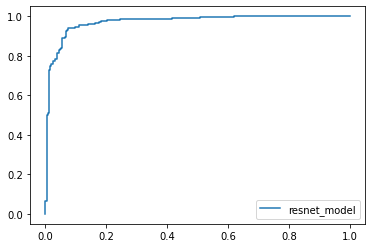

In [28]:
# calculate roc curve FOR TEST SET
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)

#plot the roc curve
plt.plot(fpr,tpr,label="resnet_model")
plt.legend(loc=4)
plt.show()

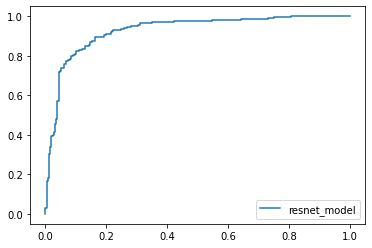

In [29]:
# calculate roc curve FOR ADVERSARIAL SET
a_fpr, a_tpr, a_thresholds = metrics.roc_curve(y_true, adv_pred)

#plot the roc curve
plt.plot(a_fpr,a_tpr,label="resnet_model")
plt.legend(loc=4)
plt.show()

In [30]:
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))

# locate the index of the largest g-mean
ix = np.argmax(gmeans)
optimal_threshold=thresholds[ix]
print('Best Unperturbed Threshold=%f, G-Mean=%.3f' % (optimal_threshold, gmeans[ix]))

Best Unperturbed Threshold=0.289114, G-Mean=0.932


In [31]:
y_pred_index = []
for i,pred in enumerate(y_pred):
    if pred >= optimal_threshold:
        y_pred_index.append(1)
    else:
        y_pred_index.append(0)

In [32]:
metrics.accuracy_score(y_true, y_pred_index)

0.932

In [33]:
# calculate the g-mean for each threshold
gmeans = np.sqrt(a_tpr * (1-a_fpr))

# locate the index of the largest g-mean
ix = np.argmax(gmeans)
optimal_threshold=thresholds[ix]
print('Best Adversarial Threshold=%f, G-Mean=%.3f' % (optimal_threshold, gmeans[ix]))

Best Adversarial Threshold=0.012449, G-Mean=0.865


In [34]:
adv_pred_index = []
for i,pred in enumerate(adv_pred):
    if pred >= optimal_threshold:
        adv_pred_index.append(1)
    else:
        adv_pred_index.append(0)

In [35]:
metrics.accuracy_score(y_true, adv_pred_index)

0.838

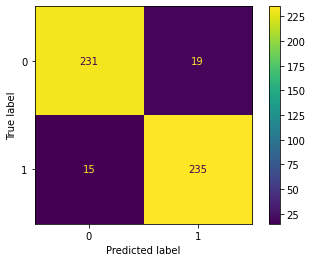

In [36]:
# Unperturbed confusion matrix
cm = confusion_matrix(y_true, y_pred_index)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

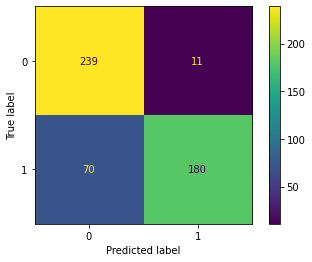

In [37]:
# Adversarial confusion matrix
cm = confusion_matrix(y_true, adv_pred_index)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [38]:
quality = [100, 90, 80, 70, 60, 50, 40, 30 , 20 , 10]

for di in reg_results:
    reg_loss.append(di['loss'])
    reg_accuracy.append(di['accuracy'])
    reg_auc.append(di['auc'])
    
for di in adv_results:
    adv_loss.append(di['loss'])
    adv_accuracy.append(di['accuracy'])
    adv_auc.append(di['auc'])

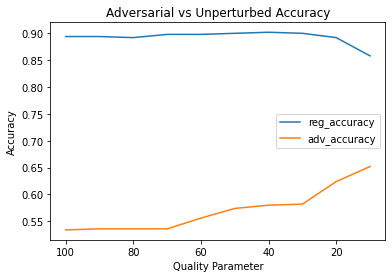

In [39]:
plot1 = plt.axes()
plot1.plot(quality, reg_accuracy, label = 'reg_accuracy')
plot1.plot(quality, adv_accuracy, label = 'adv_accuracy')

plot1.set_xlabel('Quality Parameter')
plot1.set_ylabel('Accuracy')

plot1.set_title('Adversarial vs Unperturbed Accuracy')

plt.legend()
plot1.invert_xaxis()
plt.show()

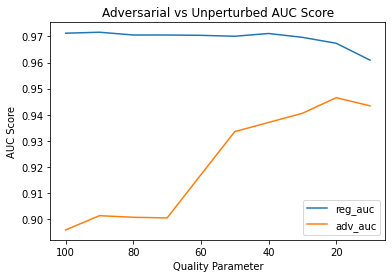

In [40]:
plot2 = plt.axes()

plot2.plot(quality, reg_auc, label = 'reg_auc')
plot2.plot(quality, adv_auc, label = 'adv_auc')

plot2.set_xlabel('Quality Parameter')
plot2.set_ylabel('AUC Score')

plot2.set_title('Adversarial vs Unperturbed AUC Score')

plt.legend()
plot2.invert_xaxis()
plt.show()

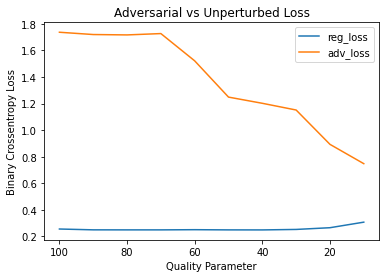

In [41]:
plot3 = plt.axes()

plot3.plot(quality, reg_loss, label = 'reg_loss')
plot3.plot(quality, adv_loss, label = 'adv_loss')

plot3.set_xlabel('Quality Parameter')
plot3.set_ylabel('Binary Crossentropy Loss')

plot3.set_title('Adversarial vs Unperturbed Loss')

plt.legend()
plot3.invert_xaxis()
plt.show()